In [1]:
import fastmri
import torch
import numpy as np
from fastmri.data.mri_data import SliceDataset
from fastmri.models import Unet
from fastmri.data.subsample import RandomMaskFunc,EquiSpacedMaskFunc,EquispacedMaskFractionFunc
from fastmri.data import transforms as T
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
## build model load weight
model = Unet(in_chans=1, out_chans=1, chans=256, num_pool_layers=4, drop_prob=0.0).cuda()
checkpoint = torch.load('./ckpt/unet_m4raw_init.ckpt')["state_dict"]
checkpoint = {k.replace("unet.", "",1): v for k, v in checkpoint.items()}

model.load_state_dict(checkpoint, strict=True)
model.eval()
del checkpoint

In [3]:
dataset = SliceDataset(root='/data/M4Raw/multicoil_val',challenge='multicoil',
                       transform=T.UnetDataTransform('multicoil',mask_func = EquispacedMaskFractionFunc(center_fractions=[0.1171875], accelerations=[2])))
d = dataset[0]
for i in d:
    try:
        print(i.shape)
    except:
        print(i)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False,
                            num_workers=4,drop_last=False,pin_memory=True)

torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([])
torch.Size([])
2022061001_FLAIR01.h5
0
()


In [4]:
from torchmetrics.functional import structural_similarity_index_measure as SSIM
from torchmetrics.functional import peak_signal_noise_ratio as PSNR
ssim_list = []
psnr_list = []
for index,d in enumerate(tqdm(val_loader)):
    with torch.no_grad():
        pre = model(d[0].unsqueeze(1).cuda())
        ssim_list.append(SSIM(pre,d[1].unsqueeze(1).cuda()).item())
        psnr_list.append(PSNR(pre,d[1].unsqueeze(1).cuda()).item())

print(f'SSIM:{sum(ssim_list)/len(ssim_list)}\nPSNR:{sum(psnr_list)/len(psnr_list)}')


100%|██████████| 6912/6912 [15:37<00:00,  7.38it/s]

SSIM:0.7104283734526554
PSNR:29.57394768959946


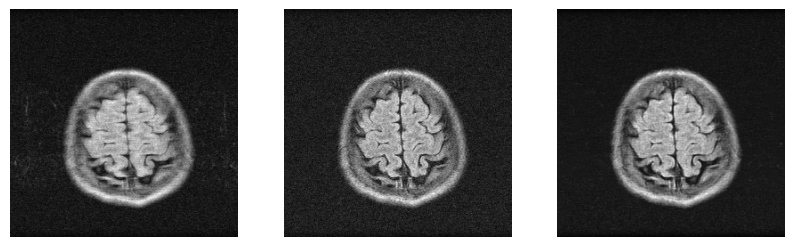

In [12]:
## visual result input/target/predict
from matplotlib import pyplot as plt
def show(data, slice_nums, cmap='gray'):
    fig = plt.figure(figsize=(10, 10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)   
        plt.axis('off')
    # plt.savefig('./show_r=3.png',dpi=400,bbox_inches = 'tight')
show([d[0][0].numpy(),d[1][0].numpy(),pre[0][0].cpu().numpy()],[0,1,2])